# Building GAN to generate even numbers

The following code builds a GAN (Generative Adversarial Network) that generates even numbers between zero and a number. First Generator and Discriminator modules are built, following which GAN is built. The data for the model is generated randomly for a batch size, which is used by the model for training the discriminator network.

After training, some values are generated using the model to check the functioning of GAN

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

## Generator and Discriminator Modules

In [2]:
class Generator(nn.Module):

    def __init__(self, input_length: int):
    
        super().__init__()

        self.dense_layer = nn.Linear(int(input_length), int(input_length))
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense_layer(x))

In [3]:
class Discriminator(nn.Module):
    def __init__(self, input_length: int):
        super().__init__()

        self.dense_layer = nn.Linear(int(input_length), 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense_layer(x))

## Util functions for converting data to binary and visa-versa

In [4]:
def number_to_binary(num, input_size):
    # input_size = 7
    ret = np.zeros(input_size)
    for i in reversed(range(input_size)):
        ret[i] = num % 2
        num >>= 1
    return ret

def binary_to_number(num_arr, input_size):
    ans = 0
    num_arr = torch.round(num_arr).to(torch.int32)

    for i in range(input_size):
        ans <<= 1
        ans += num_arr[i]
    return ans

def sample_even_data(input_size, max_int, batch_size):
    data = torch.randint(0, max_int//2, size=(batch_size, 1)) * 2
    data_bin = torch.tensor(np.array([number_to_binary(num.item(), input_size) for num in data]))
    return torch.ones(batch_size, 1), data_bin

### Testing module

In [5]:
sampled = sample_even_data(7, 50, 5)
print(sampled[1][1])
binary_to_number(sampled[1][1], 7)

tensor([0., 1., 0., 1., 0., 0., 0.], dtype=torch.float64)


tensor(40, dtype=torch.int32)

## GAN module

In [6]:
class GAN(nn.Module):
    def __init__(self, input_length: int, lr=0.002):

        super().__init__()
        self.generator = Generator(input_length)
        self.discriminator = Discriminator(input_length)

        self.generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr)
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        self.input_length = input_length
        self.loss = nn.BCELoss()

    def train_epoch(self, max_int, batch_size, input_length):
        
        # training Generator network, while Discriminator is Static
        self.generator_optimizer.zero_grad()

        noise = torch.randint(0, 2, size=(batch_size, input_length)).float()

        generated_data = self.generator(noise)

        true_labels, true_data = sample_even_data(input_length, max_int, batch_size=batch_size)

        true_labels = torch.tensor(true_labels).float()
        true_data = torch.tensor(true_data).float()

        generator_discriminator_out = self.discriminator(generated_data)
        generator_loss = self.loss(generator_discriminator_out, true_labels)
        generator_loss.backward()
        self.generator_optimizer.step()

        # training Discriminator while Generator is static

        self.discriminator_optimizer.zero_grad()

        true_discriminator_out = self.discriminator(true_data)
        true_discriminator_loss = self.loss(true_discriminator_out, true_labels)

        generator_discriminator_out = self.discriminator(generated_data.detach())
        generator_discriminator_loss = self.loss(generator_discriminator_out, torch.zeros(batch_size, 1))

        discriminator_loss = (generator_discriminator_loss + true_discriminator_loss) / 2 

        discriminator_loss.backward()
        self.discriminator_optimizer.step()

        return generator_loss, discriminator_loss

    def fit(self, max_int: int = 128, batch_size: int = 16, training_steps: int = 100):
        for i in range(training_steps):
            generator_loss, discriminator_loss = self.train_epoch(max_int, batch_size, self.input_length)
            
            if not i % (training_steps / 10):
                print(f"Training Epoch: {i} Generator_loss: {generator_loss} Discriminator_loss: {discriminator_loss}")

    def generate(self, noise=None, samples=1):

        generated_samples = torch.zeros(samples)
        
        for i in range(samples):
            if noise is None:
                noise = torch.randint(0, 2, size=(1, self.input_length)).float()
            
            generator_res = self.generator(noise).detach()[0].apply_(lambda x: 1 if x > 0.5 else 0)
            generated_samples[i] = binary_to_number(generator_res, input_size=self.input_length)
            noise = None

        return generated_samples


### Training GAN on binary dataset

In [7]:
INPUT_LENGTH = 7
TRAINING_STEPS = 10

In [8]:
model = GAN(INPUT_LENGTH)
model.fit(training_steps=TRAINING_STEPS)

Training Epoch: 0 Generator_loss: 0.6271079182624817 Discriminator_loss: 0.6895273923873901
Training Epoch: 1 Generator_loss: 0.6241930723190308 Discriminator_loss: 0.7414681911468506
Training Epoch: 2 Generator_loss: 0.6131768226623535 Discriminator_loss: 0.7192364931106567
Training Epoch: 3 Generator_loss: 0.6267352104187012 Discriminator_loss: 0.7453137040138245
Training Epoch: 4 Generator_loss: 0.6161572933197021 Discriminator_loss: 0.7694956064224243
Training Epoch: 5 Generator_loss: 0.6224527359008789 Discriminator_loss: 0.7655220031738281
Training Epoch: 6 Generator_loss: 0.6251683235168457 Discriminator_loss: 0.742914080619812
Training Epoch: 7 Generator_loss: 0.623621940612793 Discriminator_loss: 0.730674147605896
Training Epoch: 8 Generator_loss: 0.6316097378730774 Discriminator_loss: 0.7577064633369446
Training Epoch: 9 Generator_loss: 0.6246239542961121 Discriminator_loss: 0.7081093788146973


C:\Users\patel\AppData\Local\Temp\ipykernel_34108\2928542728.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(true_labels).float()
C:\Users\patel\AppData\Local\Temp\ipykernel_34108\2928542728.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_data = torch.tensor(true_data).float()


### Generating values from GAN

In [9]:
# Number of samples to generate
num_samples = 10

In [10]:
model.generate(samples=num_samples)

tensor([107., 109., 108., 104., 123., 126.,  91., 121., 125., 125.])

### Distribution of Generated Values

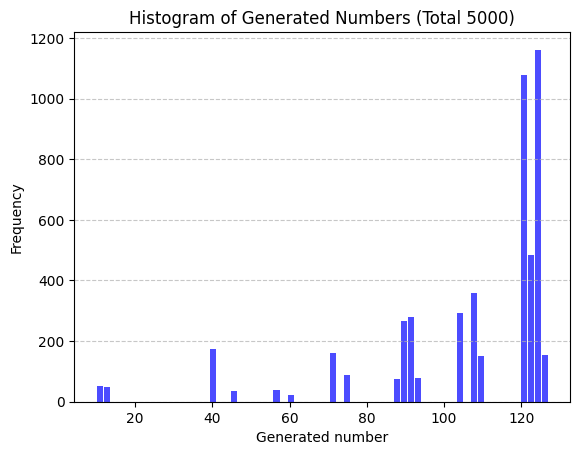

In [11]:
TEST_SAMPLES = 5000

generated_vals = model.generate(samples=TEST_SAMPLES)

plt.hist(generated_vals.numpy(), bins=64, alpha=0.7, color='blue', rwidth=0.85)
plt.title('Histogram of Generated Numbers (Total 5000)')
plt.xlabel('Generated number')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

NOTE: Changing the number of epochs, massively affects the distribution of the above graph. 